# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import csv
import random
from camel_tools.tokenizers.word import simple_word_tokenize
from collections import Counter
from utils.textnormalization import TextNormalization
from utils.machinelearning import machine_learning_model, fit_model, metrics_values, confusion_matrix_
from utils.deeplearning import convolutional_neural_network_1d, model_compile, model_fit, evaluate, plot_accuracy_loss, lstm_, gru_, bidirectional_lstm, simple_rnn
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.deeplearning_preprcosesing import  deeplearning_preprcosesing_
from utils.word_2_vec import word_2_vec_
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [4]:
Corpus = pd.read_excel('original_dataset.xlsx')
Corpus.rename(columns={'rating': 'Sentiment', 'review_description': 'Review'}, inplace=True)
Corpus.drop(columns=['company', 'Unnamed: 0'], inplace=True)
Corpus['Review'] = Corpus['Review'].astype(str)

In [5]:
Data = pd.read_csv('ArabicData.csv') # This Data Will Be Use For Word2Vec

# Sentiment Information

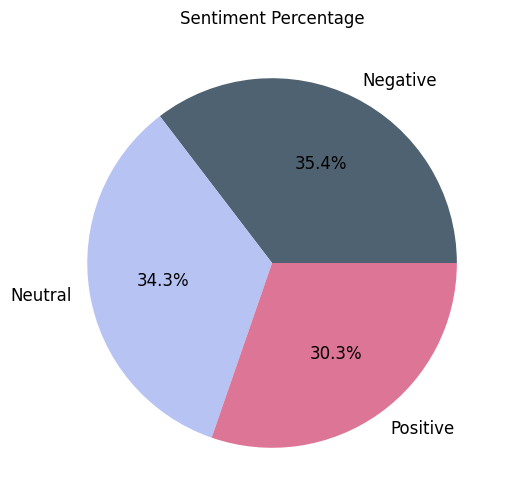

In [6]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

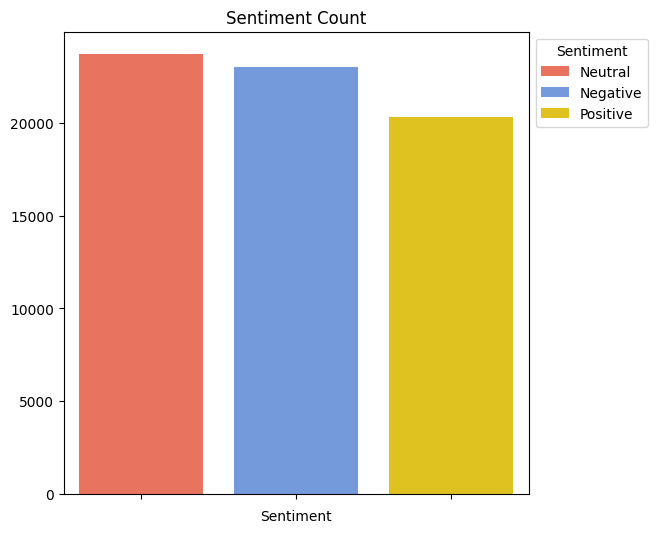

In [7]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

121704

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

2

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

176

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Text Normalization

In [12]:
Corpus["Number of Words 1"] = Corpus["Review"].apply(lambda n:len(word_tokenize(n)))
Corpus["Number of Words 1"].sum()

1680722

# Average Number Of Words Before Text Normalization

In [13]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

25

# Maximum Number Of Word Before Text Normalization

In [14]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

1601

# Minimum Number Of Words Before Text Normalization

In [15]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

1

# Number Of Charachters Before Text Normalization

In [16]:
Corpus["Number of Charachters 1"] = Corpus["Review"].str.len()
Corpus["Number of Charachters 1"].sum()

8721971

# Average Number Of Charachters Before Text Normalization

In [17]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

130

# Maximum Number Of Charachters Before Text Normalization

In [18]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

8101

# Minimum Number Of Charachters Before Text Normalization

In [19]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

1

# Most Frequent Words Before Text Normalization

In [20]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

,Word,Count
1,من,34702
2,في,31843
3,و,24583
4,.,15871
5,لا,12888
6,على,12887
7,جدا,12581
8,ما,10910
9,..,10097
10,عن,8739


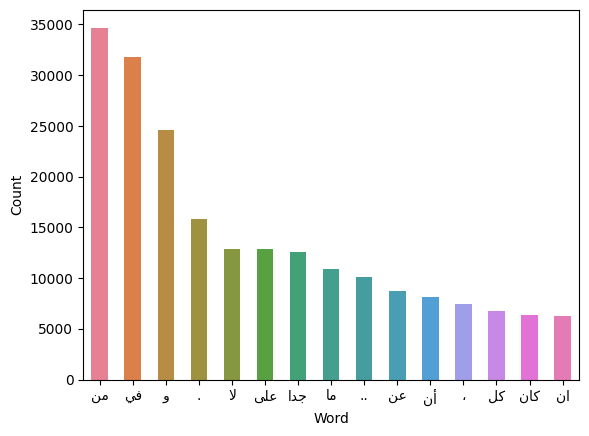

In [21]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Text Normalization

In [22]:
text_normalization = TextNormalization(_remove_emojis = True,
                                        _remove_hashtags = True,
                                        _remove_emails = True ,
                                        _remove_url = True,
                                        _remove_mention = True,
                                        _remove_duplicate_char = True,
                                        _remove_single_char = True,
                                        _remove_special_character_ = True,
                                        _remove_new_line_char = True,
                                        _remove_number = True,
                                        _remove_html_tags = True,
                                        _remove_arabic_diacritics_ = True,
                                        _normalize_arabic_unicode_ = True,
                                        _normalize_alef_maksura_ar_ = True,
                                        _normalize_alef_ar_ = True,
                                        _normalize_teh_marbuta_ar_ = True,
                                        _remove_non_arabic = True,
                                        _remove_whitespace_ = True,
                                        _remove_unicode_characters_ = True,
                                        _remove_longest_than_ = True,
                                        _remove_stop_words = True,
                                        _lemmatizer_ = False,
                                        _stemmer_ = True)

In [23]:
Corpus['Normalized_Review'] = Corpus['Review'].apply(lambda x: text_normalization.normalization(x))

In [24]:
Corpus.dropna(axis=1, inplace=True)

# Number Of Unique Words

In [25]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

53101

# WordCloud

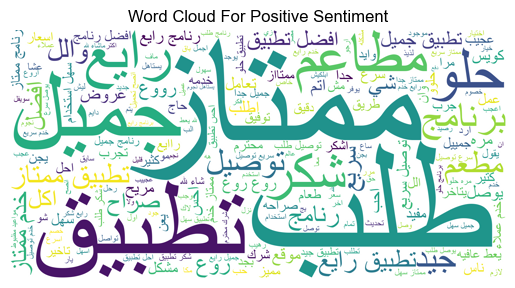

In [26]:
wordcloud(data=Corpus, target='Positive', width=2000, hieght=1000, review='Normalized_Review')

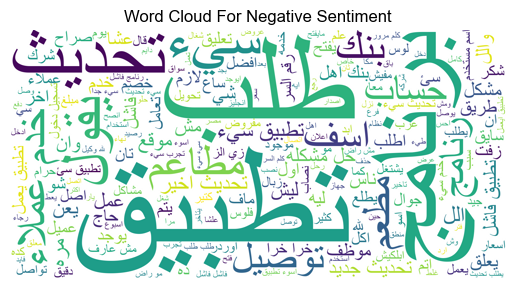

In [27]:
wordcloud(data=Corpus, target='Negative', width=2000, hieght=1000, review='Normalized_Review')

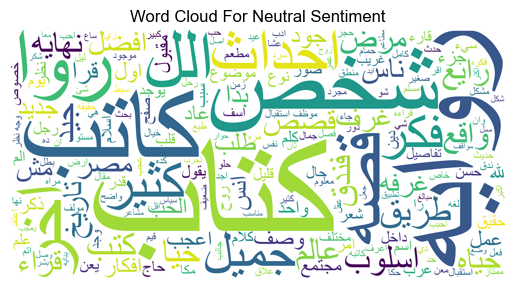

In [28]:
wordcloud(data=Corpus, target='Neutral', width=2000, hieght=1000, review='Normalized_Review')

# Number Of Words After Text Normalization

In [29]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(word_tokenize(n)))
Corpus.drop(Corpus[Corpus["Number of Words 2"] == 0].index, inplace = True)
Corpus["Number of Words 2"].sum()

1039837

# Average Number Of Words After Text Normalization

In [30]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

16

# Maximum Number Of Word After Text Normalization

In [31]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

922

# Minimum Number Of Words After Text Normalization

In [32]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

1

# Number Of Charachters After Text Normalization

In [33]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].str.len()
Corpus["Number of Charachters 2"].sum()

5058765

# Average Number Of Charachters After Text Normalization

In [34]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

78

# Maximum Number Of Charachters After Text Normalization

In [35]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

4610

# Minimum Number Of Charachters After Text Normalization

In [36]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

1

# Most Frequent Words After Text Normalization

In [37]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

,Word,Count
1,تطبيق,11564
2,كتاب,9313
3,طلب,8033
4,روايه,6052
5,سيء,5324
6,خدم,4977
7,ممتاز,4931
8,جيد,4756
9,جميل,4584
10,تحديث,4150


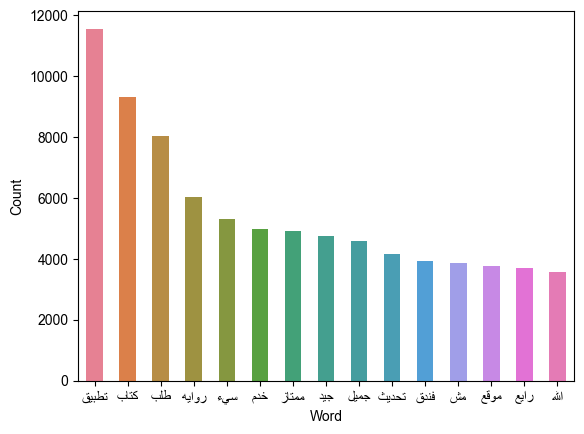

In [38]:
bar_plot(data=MostFrequentWordDF2, text = 'Word', x = 'Word', y='Count')

# Split The Dataset Into X And y

In [39]:
X, y = Corpus['Normalized_Review'], Corpus['Sentiment']
le = LabelEncoder()
y = le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# CountVectorizer

In [41]:
CountVectorizer_ = CountVectorizer()
X_train_CV_ = CountVectorizer_.fit_transform(X_train)
X_test_CV_ = CountVectorizer_.transform(X_test)

In [42]:
Vocabulary = CountVectorizer_.vocabulary_
Vocabulary

{'يوجد': 47235,
 'مشكل': 34444,
 'كود': 27743,
 'خصم': 15266,
 'مش': 34297,
 'راض': 16706,
 'يشتغل': 45769,
 'مطعم': 34819,
 'قال': 26051,
 'شي': 21087,
 'مضبوط': 34684,
 'يفتح': 46286,
 'ادر': 1838,
 'سبب': 18567,
 'تحديث': 9041,
 'جوال': 13419,
 'حلا': 14491,
 'يرج': 45289,
 'انتباه': 5421,
 'مشكله': 34448,
 'منطقه': 36745,
 'كفر': 27461,
 'جايز': 12614,
 'شكر': 20845,
 'ده': 16177,
 'انت': 5413,
 'ابليكش': 437,
 'زبال': 17834,
 'خدم': 15042,
 'عملاء': 23885,
 'زي': 18139,
 'الخ': 4751,
 'كتكم': 27131,
 'قرف': 26350,
 'قر': 26282,
 'اسف': 3043,
 'هي': 40869,
 'مذاك': 33326,
 'باطنه': 6983,
 'فمش': 25717,
 'قادر': 25995,
 'اقيم': 4449,
 'او': 6125,
 'صالح': 21241,
 'هيص': 40981,
 'فارق': 24918,
 'معا': 34929,
 'الدن': 4775,
 'الل': 4964,
 'فهم': 25830,
 'هيصه': 40984,
 'ناس': 37875,
 'تمو': 11529,
 'فاستقل': 24948,
 'وبق': 42919,
 'عايش': 22973,
 'دماغ': 16106,
 'وطظ': 43347,
 'اقول': 4440,
 'ان': 5334,
 'اعجب': 3781,
 'شخص': 20528,
 'بطل': 7495,
 'تان': 8121,
 'روايه': 17478,
 'مبسوط

# Machine Learning

**1-Naive Bayes**

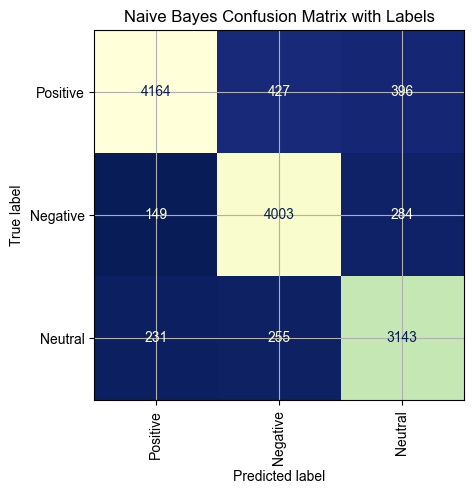

In [43]:
Algorithm = MultinomialNB(alpha= 1)
Naive_Bayes = machine_learning_model(algorithm=Algorithm)
fit_model(model=Naive_Bayes, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Naive_Bayes, X_test=X_test_CV_, y_test=y_test, name='Naive Bayes')

In [44]:
metrics_values(model= Naive_Bayes, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.866534
Precision,0.867813
Recall,0.864310
F1Score,0.865022
Error,0.133466


**2-Logistic Regression**

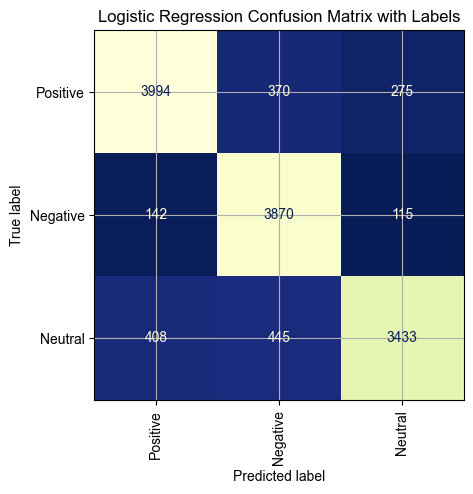

In [45]:
Algorithm = LogisticRegression()
Logistic_Regression = machine_learning_model(algorithm=Algorithm)
fit_model(model=Logistic_Regression, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(Logistic_Regression, X_test=X_test_CV_, y_test=y_test, name='Logistic Regression')

In [46]:
metrics_values(model= Logistic_Regression, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.865538
Precision,0.866556
Recall,0.867663
F1Score,0.864976
Error,0.134462


**3-Decision Tree**

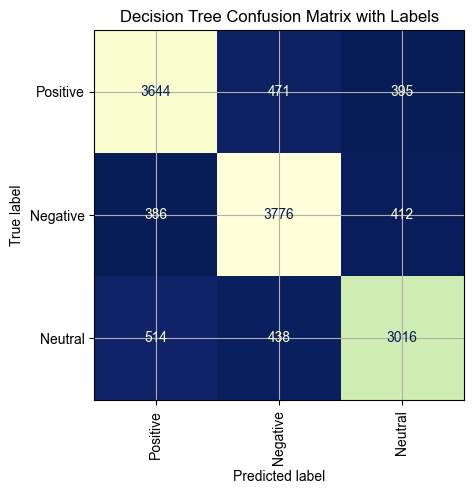

In [47]:
Algorithm = DecisionTreeClassifier(criterion='gini')
Decision_Tree = machine_learning_model(algorithm=Algorithm)
fit_model(model=Decision_Tree, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Decision_Tree, X_test=X_test_CV_, y_test=y_test, name='Decision Tree')

In [48]:
metrics_values(model= Decision_Tree, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.799571
Precision,0.797866
Recall,0.798941
F1Score,0.798271
Error,0.200429


**4-K Nearest Neighbors**

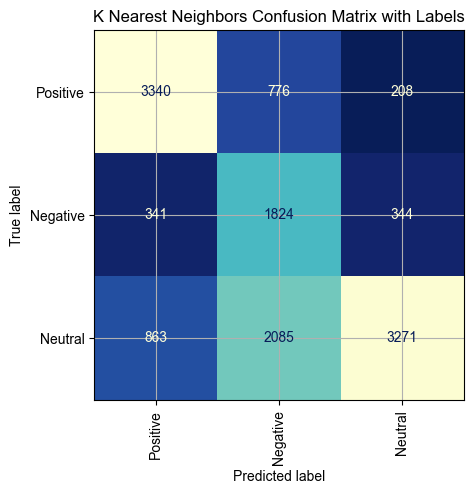

In [49]:
Algorithm =KNeighborsClassifier(metric='manhattan', n_neighbors=5)
K_Nearest_Neighbors = machine_learning_model(algorithm=Algorithm)
fit_model(model=K_Nearest_Neighbors, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test, name='K Nearest Neighbors')

In [50]:
metrics_values(model= K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.646261
Precision,0.675128
Recall,0.659991
F1Score,0.637274
Error,0.353739


**5-Random Forest**

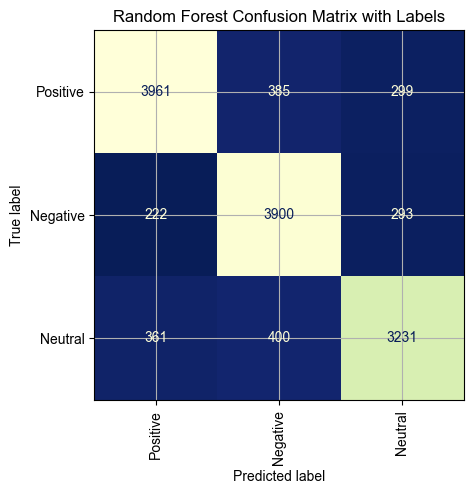

In [51]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=300)
Random_Forest = machine_learning_model(algorithm=Algorithm)
fit_model(model=Random_Forest, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Random_Forest, X_test=X_test_CV_, y_test=y_test, name='Random Forest')

In [52]:
metrics_values(model= Random_Forest, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.849831
Precision,0.848489
Recall,0.849764
F1Score,0.848711
Error,0.150169


**6-SGD Classifier**

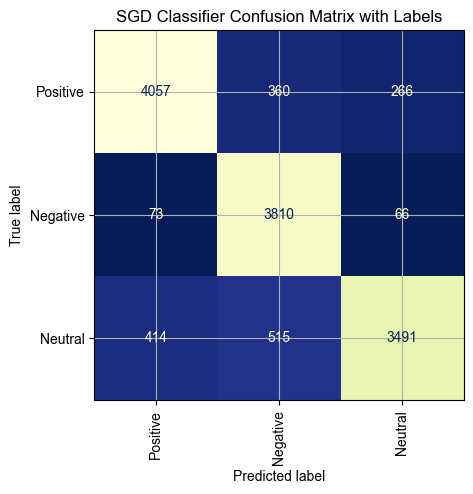

In [53]:
Algorithm = SGDClassifier(loss='hinge')
SGD = machine_learning_model(algorithm=Algorithm)
fit_model(model=SGD, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SGD, X_test=X_test_CV_, y_test=y_test, name='SGD Classifier')

In [54]:
metrics_values(model= SGD, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.870211
Precision,0.873648
Recall,0.873072
F1Score,0.869652
Error,0.129789


**7-SVM**

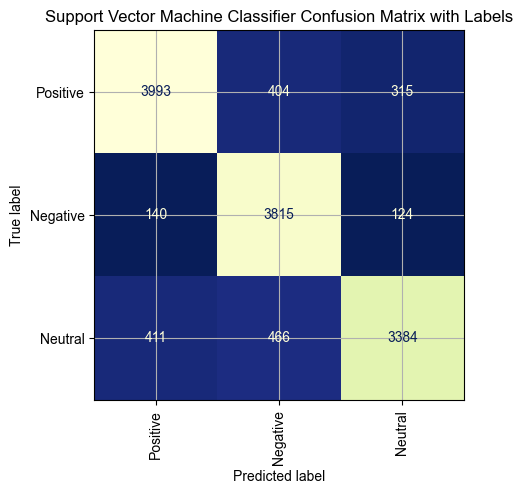

In [55]:
Algorithm = SVC(kernel='linear')
SVM = machine_learning_model(algorithm=Algorithm)
fit_model(model=SVM, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SVM, X_test=X_test_CV_, y_test=y_test, name='Support Vector Machine Classifier')

In [56]:
metrics_values(model= SVM, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.857493
Precision,0.858956
Recall,0.859404
F1Score,0.856869
Error,0.142507


**8-MLPClassifier**

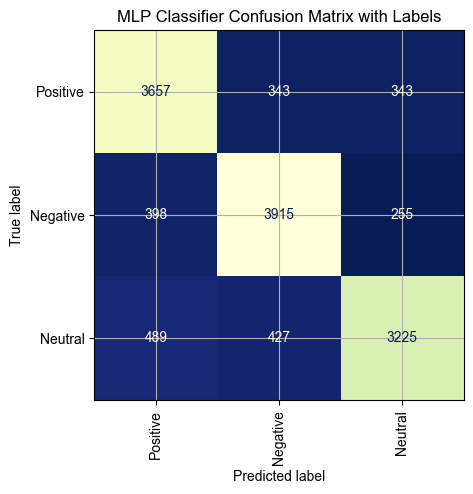

In [57]:
Algorithm = MLPClassifier(activation='relu', hidden_layer_sizes=16)
MLP = machine_learning_model(algorithm=Algorithm)
fit_model(model=MLP, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=MLP, X_test=X_test_CV_, y_test=y_test, name='MLP Classifier')

In [58]:
metrics_values(model= MLP, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.827230
Precision,0.825964
Recall,0.828007
F1Score,0.826369
Error,0.172770


# Build Word2Vec

In [59]:
word_2_vec_(data = Data['Text'], vector_size=100, sg = 0, name = 'ArabicWord2Vec100D')

# Deep Learning

In [60]:
tokenizer, vocab_size, max_length, encoded_X_train , encoded_X_test, encoded_y_train, encoded_y_test= deeplearning_preprcosesing_(X_train=X_train, X_test=X_test,  truncating='pre', padding='pre', y_train_=y_train, y_test_=y_test)
embedding_dim = 100

In [61]:
print('The Vocab Size Is :',vocab_size)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 47470

The Max Length Is : 922


In [62]:
Arabic_Word_2_Vec_100D = './ArabicWord2Vec100D.txt'
embedding_dic = {}
with open(Arabic_Word_2_Vec_100D) as f:
    for line in f:
        values = line.split()
        word = values[0]
        x = np.asarray(values[1:], dtype='float32')
        embedding_dic[word] = x

In [63]:
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                    patience=3
                )

**9-LSTM**

Epoch 1/10
1632/1632 [==============================] - 220s 133ms/step - loss: 0.5781 - accuracy: 0.7565 - val_loss: 0.3062 - val_accuracy: 0.8593
Epoch 2/10
1632/1632 [==============================] - 202s 124ms/step - loss: 0.2565 - accuracy: 0.8787 - val_loss: 0.2634 - val_accuracy: 0.8711
Epoch 3/10
1632/1632 [==============================] - 202s 124ms/step - loss: 0.2098 - accuracy: 0.8985 - val_loss: 0.2570 - val_accuracy: 0.8732
Epoch 4/10
1632/1632 [==============================] - 207s 127ms/step - loss: 0.1837 - accuracy: 0.9106 - val_loss: 0.2562 - val_accuracy: 0.8721
Epoch 5/10
1632/1632 [==============================] - 212s 130ms/step - loss: 0.1675 - accuracy: 0.9181 - val_loss: 0.2520 - val_accuracy: 0.8741
Epoch 6/10
1632/1632 [==============================] - 209s 128ms/step - loss: 0.1559 - accuracy: 0.9237 - val_loss: 0.2585 - val_accuracy: 0.8682
Epoch 7/10
1632/1632 [==============================] - 206s 127ms/step - loss: 0.1468 - accuracy: 0.9277 - val_

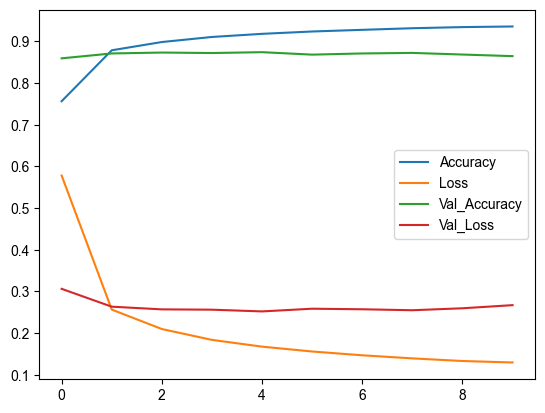

 
The Training Loss is 0.1220, And Training Accuracy is 0.9399
 
The Testing Loss is 0.2671, And Testing Accuracy is 0.8646


In [65]:
LSTM =lstm_(vocab_size= vocab_size + 1, embedding_dim= embedding_dim, max_length= max_length, dropout=0.5, units=32, embeddings_matrix = embedding_matrix, units_= 32)
model_compile(model=LSTM)
history = model_fit(model=LSTM, X_train=encoded_X_train, y_train=encoded_y_train, epochs=10, X_test=encoded_X_test, y_test=encoded_y_test, batch_size=32, Callback=Callback)
plot_accuracy_loss(histoty=history)
evaluate(model=LSTM, x=encoded_X_train, y=encoded_y_train, train_test='Training')
evaluate(model=LSTM, x=encoded_X_test,y= encoded_y_test, train_test='Testing')  

**10-GRU**

Epoch 1/10
1632/1632 [==============================] - 209s 127ms/step - loss: 0.6527 - accuracy: 0.6816 - val_loss: 0.3164 - val_accuracy: 0.8510
Epoch 2/10
1632/1632 [==============================] - 216s 132ms/step - loss: 0.2576 - accuracy: 0.8762 - val_loss: 0.2628 - val_accuracy: 0.8711
Epoch 3/10
1632/1632 [==============================] - 211s 129ms/step - loss: 0.2085 - accuracy: 0.8979 - val_loss: 0.2573 - val_accuracy: 0.8727
Epoch 4/10
1632/1632 [==============================] - 208s 127ms/step - loss: 0.1822 - accuracy: 0.9103 - val_loss: 0.2573 - val_accuracy: 0.8714
Epoch 5/10
1632/1632 [==============================] - 203s 124ms/step - loss: 0.1667 - accuracy: 0.9175 - val_loss: 0.2551 - val_accuracy: 0.8723
Epoch 6/10
1632/1632 [==============================] - 190s 117ms/step - loss: 0.1554 - accuracy: 0.9232 - val_loss: 0.2580 - val_accuracy: 0.8706
Epoch 7/10
1632/1632 [==============================] - 189s 116ms/step - loss: 0.1474 - accuracy: 0.9270 - val_

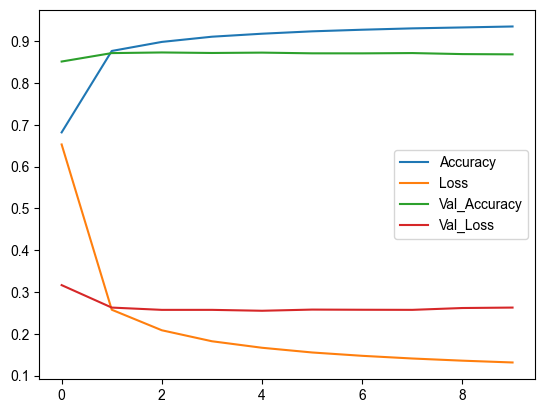

 
The Training Loss is 0.1264, And Training Accuracy is 0.9370
 
The Testing Loss is 0.2628, And Testing Accuracy is 0.8681


In [66]:
GRU_=gru_(vocab_size= vocab_size + 1, embedding_dim= embedding_dim, max_length= max_length, dropout=0.5, units=32, embeddings_matrix = embedding_matrix, units_ = 32)
model_compile(model=GRU_)
history = model_fit(model=GRU_, X_train=encoded_X_train, y_train=encoded_y_train, epochs=10, X_test=encoded_X_test, y_test=encoded_y_test, batch_size=32, Callback=Callback)
plot_accuracy_loss(histoty=history)
evaluate(model=GRU_, x=encoded_X_train, y=encoded_y_train, train_test='Training')
evaluate(model=GRU_, x=encoded_X_test,y= encoded_y_test, train_test='Testing')  

**11-Bidirectional LSTM** 

Epoch 1/10
1632/1632 [==============================] - 329s 199ms/step - loss: 0.5650 - accuracy: 0.7409 - val_loss: 0.3027 - val_accuracy: 0.8569
Epoch 2/10
1632/1632 [==============================] - 308s 188ms/step - loss: 0.2565 - accuracy: 0.8774 - val_loss: 0.2627 - val_accuracy: 0.8721
Epoch 3/10
1632/1632 [==============================] - 302s 185ms/step - loss: 0.2127 - accuracy: 0.8967 - val_loss: 0.2533 - val_accuracy: 0.8746
Epoch 4/10
1632/1632 [==============================] - 304s 186ms/step - loss: 0.1862 - accuracy: 0.9092 - val_loss: 0.2538 - val_accuracy: 0.8704
Epoch 5/10
1632/1632 [==============================] - 310s 190ms/step - loss: 0.1683 - accuracy: 0.9177 - val_loss: 0.2512 - val_accuracy: 0.8752
Epoch 6/10
1632/1632 [==============================] - 300s 184ms/step - loss: 0.1557 - accuracy: 0.9238 - val_loss: 0.2513 - val_accuracy: 0.8748
Epoch 7/10
1632/1632 [==============================] - 297s 182ms/step - loss: 0.1460 - accuracy: 0.9289 - val_

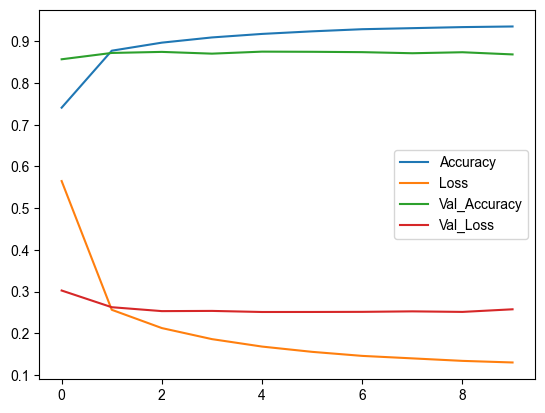

 
The Training Loss is 0.1266, And Training Accuracy is 0.9373
 
The Testing Loss is 0.2577, And Testing Accuracy is 0.8685


In [67]:
Bidirectional_LSTM=bidirectional_lstm(vocab_size= vocab_size + 1, embedding_dim= embedding_dim, max_length= max_length, dropout=0.2, units=32, embeddings_matrix = embedding_matrix, units_ = 32)
model_compile(model=Bidirectional_LSTM)
history = model_fit(model=Bidirectional_LSTM, X_train=encoded_X_train, y_train=encoded_y_train, epochs=10, X_test=encoded_X_test, y_test=encoded_y_test, batch_size=32, Callback=Callback)
plot_accuracy_loss(histoty=history)
evaluate(model=Bidirectional_LSTM, x=encoded_X_train, y=encoded_y_train, train_test='Training')
evaluate(model=Bidirectional_LSTM, x=encoded_X_test,y= encoded_y_test, train_test='Testing')  